In [40]:
import sys
import pandas as pd
import configparser
import numpy as np
import matplotlib.pyplot as plt
#from datetime import datetime
from datetime import datetime as dt
from dateutil.relativedelta import relativedelta
import warnings
warnings.filterwarnings('ignore')
from keras.models import model_from_json
from sklearn.preprocessing import MinMaxScaler

from data_helper import *
from IPython.display import display, HTML

In [41]:
config = configparser.ConfigParser()
config.read('config/mypredictorconfig.ini')

eco_tools_path = config['SETUP']['eco_tools_path']
sys.path.append(eco_tools_path)
from ecotools.pi_client import pi_client
pc = pi_client(root = 'readonly')
point_name = config['PI']['point_name']
start = config['PI']['start']
end = config['PI']['end']
interval = config['PI']['interval']
calculation = config['PI']['calculation']

look_back = int(config['MODEL']['look_back'])
anomaly_threshold = int(config['MODEL']['anomaly_threshold'])
forecast = config['MODEL']['forecast']

In [42]:
# Model reconstruction from JSON file
weight_name = config['infiles']['weight_name']
arch_name = config['infiles']['arch_name']
scaler = MinMaxScaler(feature_range=(0,1))
with open(arch_name, 'r') as f:
    model = model_from_json(f.read())

# Load weights into the new model
model.load_weights(weight_name)

In [43]:
point_list = [point_name, 'aiTIT4045']
df = pc.get_stream_by_point(point_list, start = start, end = end, calculation = calculation, interval= interval)
df.tail()

Grabbing WebIDs ...
WebID collection complete!
10:38:16: Sending API request... Chunk 1 of 1
10:38:16: Response recieved for 2 tags! (0.07)


,GBSF_Electricity_Demand_kBtu,aiTIT4045
Timestamp,,
2019-07-30 05:00:00,2721.140350,61.834781
2019-07-30 06:00:00,2809.351278,62.249637
2019-07-30 07:00:00,2800.603109,66.641392
2019-07-30 08:00:00,2885.930511,70.941281
2019-07-30 09:00:00,3005.144033,72.500578


Grabbing WebIDs ...
WebID collection complete!
11:49:35: Sending API request... Chunk 1 of 1
11:49:35: Response recieved for 1 tags! (0.04)


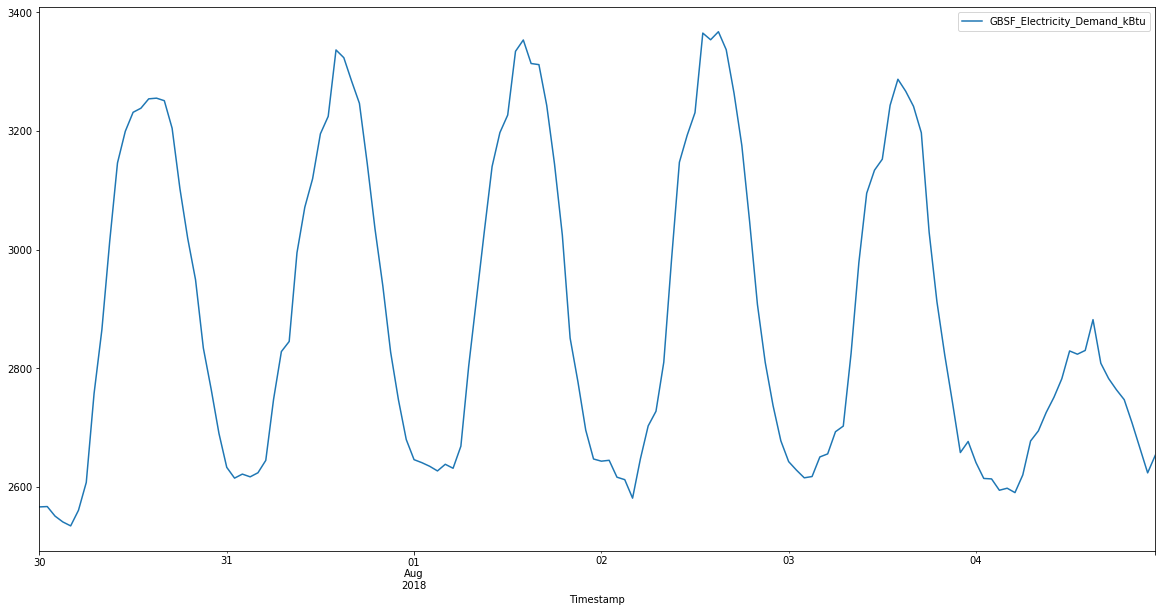

In [54]:
pc.get_stream_by_point(point_name, start = '2018-07-30', end = '2018-08-05',interval = interval, calculation = calculation).plot(figsize = (20,10))

In [44]:
df1 = pc.get_stream_by_point('Outside_Air_Temp_Forecast', end = forecast, interval = interval, calculation = calculation)#
df1.head()

Grabbing WebIDs ...
WebID collection complete!
10:38:16: Sending API request... Chunk 1 of 1
10:38:16: Response recieved for 1 tags! (0.03)


,Outside_Air_Temp_Forecast
Timestamp,
2019-07-29 00:00:00,67.0
2019-07-29 01:00:00,65.0
2019-07-29 02:00:00,63.5
2019-07-29 03:00:00,62.5
2019-07-29 04:00:00,61.0


In [45]:
new_df = pd.concat([df,df1], axis = 1, sort = False)
new_df.tail(6)

,GBSF_Electricity_Demand_kBtu,aiTIT4045,Outside_Air_Temp_Forecast
Timestamp,,,
2019-07-30 09:00:00,3005.144033,72.500578,68.5
2019-07-30 10:00:00,NaN,NaN,72.5
2019-07-30 11:00:00,NaN,NaN,76.0
2019-07-30 12:00:00,NaN,NaN,79.5
2019-07-30 13:00:00,NaN,NaN,82.5
2019-07-30 14:00:00,NaN,NaN,85.0


In [46]:
new_df['aiTIT4045'].fillna(new_df.Outside_Air_Temp_Forecast, inplace = True)
new_df.drop('Outside_Air_Temp_Forecast', axis = 1, inplace = True)
new_df.head()

,GBSF_Electricity_Demand_kBtu,aiTIT4045
Timestamp,,
2019-07-17 00:00:00,2620.899984,66.328080
2019-07-17 01:00:00,2614.991353,64.489932
2019-07-17 02:00:00,2623.946960,63.002730
2019-07-17 03:00:00,2627.607707,62.071544
2019-07-17 04:00:00,2679.489187,61.753234


In [47]:
del df, df1
values_to_predict = new_df.loc[new_df[point_name].isna()].shape[0]
values_to_predict

5

In [48]:
def generate_prediction(df):
    y = df[point_name]
    X = df.drop(columns = point_name)
    X_test = scaler.fit_transform(X)
    y_test = scaler.fit_transform(np.array(y).reshape((-1,1)))
    X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))
    prediction = model.predict(X_test)
    prediction = scaler.inverse_transform(prediction.reshape(-1,1))
    index = df.index
    result = pd.DataFrame({"Actual":scaler.inverse_transform(y_test).reshape((-1,)),
                                   "Modeled":prediction.reshape((-1,))}, index=index)
    print("Predicted")
    #display(result.tail(2))
    print(result.Modeled.iloc[-1])
    print("-------------------------------------------")
    return result.tail(2)

In [49]:
firstNaN = new_df['aiTIT4045'].index.searchsorted(new_df[point_name].isna().idxmax())
firstNaN

322

In [50]:
for i in range(values_to_predict):
    
    #find the index of where the first nan appears in outside air temp
    nan_index = new_df['aiTIT4045'].index.searchsorted(new_df[point_name].isna().idxmax())
    #print(f"NaN index: {nan_index}")
    #create a DataFrame that has the tail of 10 points and has the first NaN value 
    #of point interested in as NaN
    df = new_df.iloc[ :nan_index + 1]
 
    display(df.tail(2))
    df = create_standard_multivariable_df(df, shift = look_back, dropna = False)
    #drop all NaN values except the very last one as this is the 
    #one we are interested in predicting then append that last row
    #from df onto ddf
    ddf = df.iloc[:-1,:].dropna()
    ddf = ddf.append(df.iloc[-1], verify_integrity = True)

    result = generate_prediction(ddf)
    new_df.iloc[nan_index].fillna(result.Modeled.iloc[-1], inplace = True)

,GBSF_Electricity_Demand_kBtu,aiTIT4045
Timestamp,,
2019-07-30 09:00:00,3005.144033,72.500578
2019-07-30 10:00:00,NaN,72.500000


Predicted
2964.9543
-------------------------------------------


,GBSF_Electricity_Demand_kBtu,aiTIT4045
Timestamp,,
2019-07-30 10:00:00,2964.954346,72.5
2019-07-30 11:00:00,NaN,76.0


Predicted
3031.5698
-------------------------------------------


,GBSF_Electricity_Demand_kBtu,aiTIT4045
Timestamp,,
2019-07-30 11:00:00,3031.569824,76.0
2019-07-30 12:00:00,NaN,79.5


Predicted
3133.3477
-------------------------------------------


,GBSF_Electricity_Demand_kBtu,aiTIT4045
Timestamp,,
2019-07-30 12:00:00,3133.347656,79.5
2019-07-30 13:00:00,NaN,82.5


Predicted
3088.0464
-------------------------------------------


,GBSF_Electricity_Demand_kBtu,aiTIT4045
Timestamp,,
2019-07-30 13:00:00,3088.046387,82.5
2019-07-30 14:00:00,NaN,85.0


Predicted
3146.2275
-------------------------------------------


Text(0.5, 1.0, 'Predicting +5h')

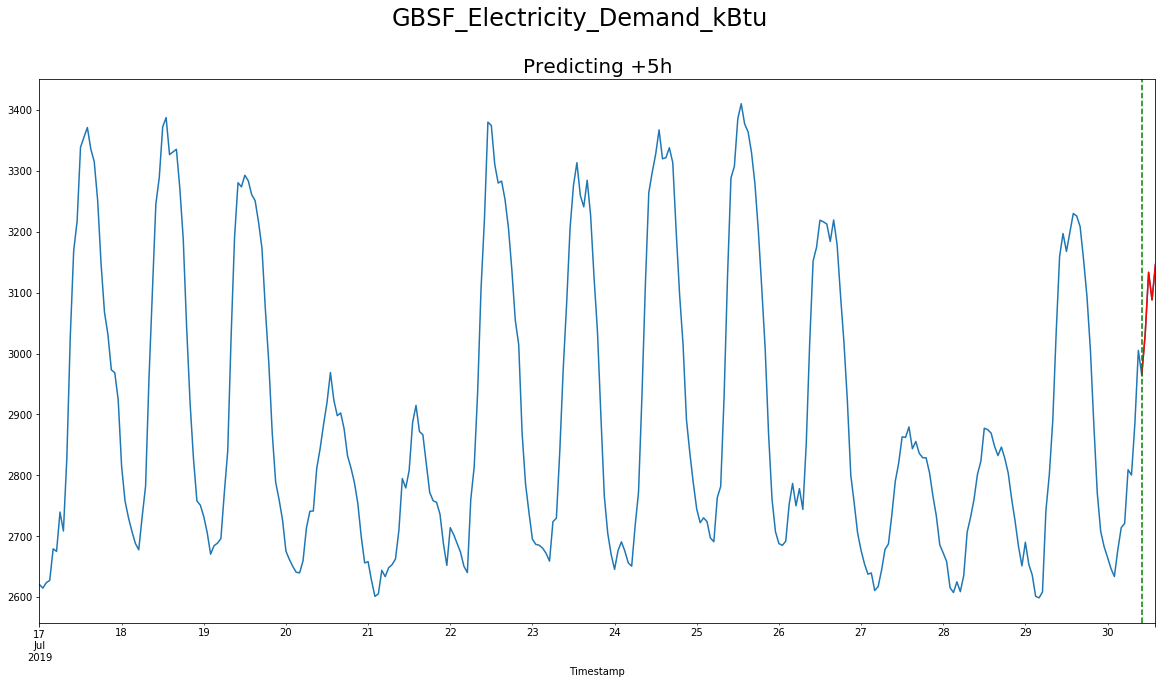

In [51]:
new_df[point_name].plot(figsize = (20,10))
new_df[point_name].iloc[firstNaN:].plot(figsize = (20,10), color = 'r')
plt.axvline(x = new_df.iloc[firstNaN].name, color = 'green', linestyle = '--')
plt.suptitle(f"{point_name}\n", fontsize = 24)
plt.title(f"Predicting {forecast}", fontsize = 20)

In [29]:
new_df[point_name].round(1)

Timestamp
2019-07-17 00:00:00    2620.9
2019-07-17 01:00:00    2615.0
2019-07-17 02:00:00    2623.9
2019-07-17 03:00:00    2627.6
2019-07-17 04:00:00    2679.5
2019-07-17 05:00:00    2675.3
2019-07-17 06:00:00    2739.8
2019-07-17 07:00:00    2708.7
2019-07-17 08:00:00    2828.5
2019-07-17 09:00:00    3026.8
2019-07-17 10:00:00    3168.5
2019-07-17 11:00:00    3217.2
2019-07-17 12:00:00    3338.6
2019-07-17 13:00:00    3355.2
2019-07-17 14:00:00    3371.1
2019-07-17 15:00:00    3335.8
2019-07-17 16:00:00    3315.1
2019-07-17 17:00:00    3251.6
2019-07-17 18:00:00    3147.5
2019-07-17 19:00:00    3067.7
2019-07-17 20:00:00    3031.4
2019-07-17 21:00:00    2973.3
2019-07-17 22:00:00    2968.6
2019-07-17 23:00:00    2924.3
2019-07-18 00:00:00    2814.8
2019-07-18 01:00:00    2758.0
2019-07-18 02:00:00    2730.7
2019-07-18 03:00:00    2708.5
2019-07-18 04:00:00    2688.7
2019-07-18 05:00:00    2677.8
                        ...  
2019-07-28 14:00:00    2869.4
2019-07-28 15:00:00    2847.7


In [30]:
new_df

,GBSF_Electricity_Demand_kBtu,aiTIT4045
Timestamp,,
2019-07-17 00:00:00,2620.899984,66.328080
2019-07-17 01:00:00,2614.991353,64.489932
2019-07-17 02:00:00,2623.946960,63.002730
2019-07-17 03:00:00,2627.607707,62.071544
2019-07-17 04:00:00,2679.489187,61.753234
2019-07-17 05:00:00,2675.266215,61.552934
2019-07-17 06:00:00,2739.819427,62.566132
2019-07-17 07:00:00,2708.734843,66.191774
2019-07-17 08:00:00,2828.456604,66.281305
